In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

<ipython-input-2-cbe8f7c99398>:13: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
<ipython-input-2-cbe8f7c99398>:13: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])


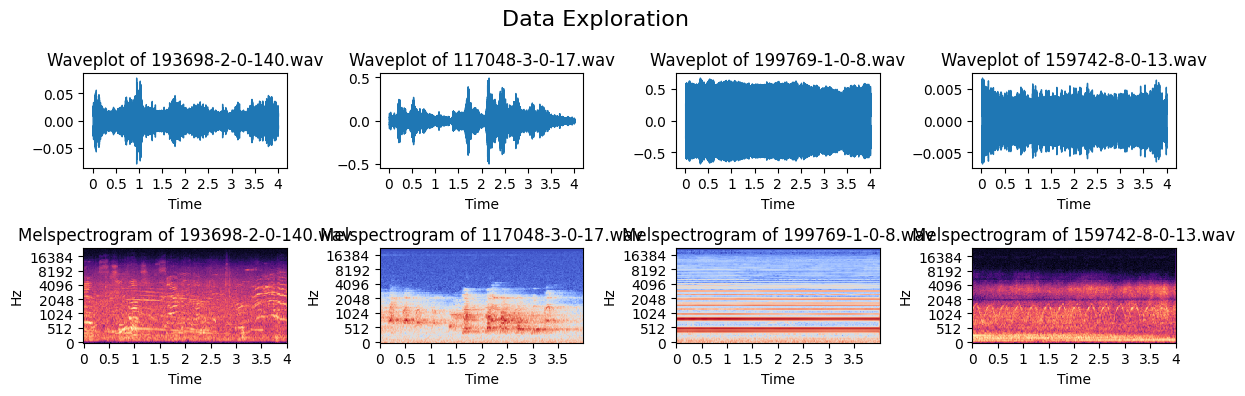

In [2]:
visualize_class = ['children_playing', 'dog_bark', 'car_horn', 'siren']

description = pd.read_csv('/content/drive/MyDrive/project/UrbanSound8K.csv')
fig, axs = plt.subplots(nrows=2, ncols=(len(visualize_class)))
axs = axs.flatten()
fig.suptitle('Data Exploration', fontsize=16)
fig.set_size_inches(12, 4)
for i, digit in enumerate(visualize_class):
    # Select random file for selected digit
    rand_file = np.random.choice(description[description['class'] == digit]['slice_file_name'])
    # Load audio and plot waveform and melspectrogram
    audio, sr = librosa.load(os.path.join('/content/drive/MyDrive/project/rec', rand_file), sr=None)
    librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
    axs[i].set(title=f'Waveplot of {rand_file}')
    mels_db = librosa.power_to_db(S=librosa.feature.melspectrogram(y=audio, sr=sr), ref=1.0)
    librosa.display.specshow(data=mels_db, sr=sr, x_axis='time', y_axis='mel', ax=axs[i+len(visualize_class)])
    axs[i+len(visualize_class)].set(title=f'Melspectrogram of {rand_file}')
plt.tight_layout()
plt.show()

In [3]:
import os
from tqdm import tqdm
import librosa
import numpy as np

feature_list = []
label_list = []

# Iterate over all files in the given source path
print('Preparing feature dataset and labels.')
for file in tqdm(os.listdir('/content/drive/MyDrive/project/rec')):
    # Skip if it's not a wav file
    if not file.endswith('.wav'):
        continue
    # Load audio and stretch it to length 1s
    audio_path = os.path.join('/content/drive/MyDrive/project/rec', file)
    audio, sr = librosa.load(path=audio_path, sr=None)
    audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)
    # Calculate features and get the label from the filename
    mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
    mels_db = librosa.power_to_db(S=mels, ref=1.0)

    # Ensure all mel spectrograms have the same number of columns (e.g., 87)
    max_columns = 87
    if mels_db.shape[1] < max_columns:
        # If fewer columns, pad with zeros
        mels_db = np.pad(mels_db, ((0, 0), (0, max_columns - mels_db.shape[1])))
    elif mels_db.shape[1] > max_columns:
        # If more columns, truncate
        mels_db = mels_db[:, :max_columns]

    # Reshape it according to the maximum number of columns
    feature_list.append(mels_db.reshape((128, -1, 1)))
    label_list.append(file[0])

features = np.array(feature_list)
labels = np.array(label_list)


Preparing feature dataset and labels.


100%|██████████| 8742/8742 [28:51<00:00,  5.05it/s]


In [4]:
TEST_SIZE = 0.3
BATCH_SIZE = 64
EPOCHS = 10
# Flatten the spectrogram data
X_flat = features.reshape(features.shape[0], -1)
# Split dataset to train and test data
X_train, X_test, y_train, y_test = train_test_split(X_flat, labels, test_size=TEST_SIZE, random_state=42)
# Initialize SVM
svm_model = SVC()
# Initialize a list to store accuracies at each iteration
epoch_accuracies = []

for epoch in range(EPOCHS):
    # Train the model
    svm_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = svm_model.predict(X_test)

    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Store the accuracy for this iteration
    epoch_accuracies.append(accuracy)

    print(f'EPOCH: {epoch + 1}/{EPOCHS} - Test Accuracy: {accuracy:.2%}')

EPOCH: 1/10 - Test Accuracy: 64.43%
EPOCH: 2/10 - Test Accuracy: 64.43%
EPOCH: 3/10 - Test Accuracy: 64.43%
EPOCH: 4/10 - Test Accuracy: 64.43%
EPOCH: 5/10 - Test Accuracy: 64.43%
EPOCH: 6/10 - Test Accuracy: 64.43%
EPOCH: 7/10 - Test Accuracy: 64.43%
EPOCH: 8/10 - Test Accuracy: 64.43%
EPOCH: 9/10 - Test Accuracy: 64.43%
EPOCH: 10/10 - Test Accuracy: 64.43%


In [5]:
# Print classification report
y_pred = svm_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           1       0.63      1.00      0.77      1547
           2       0.95      0.27      0.42       268
           3       1.00      0.20      0.33       125
           4       0.00      0.00      0.00        88
           5       1.00      0.07      0.13       116
           6       0.00      0.00      0.00       107
           7       0.85      0.18      0.30       217
           8       1.00      0.02      0.03        62
           9       0.00      0.00      0.00        93

    accuracy                           0.64      2623
   macro avg       0.60      0.19      0.22      2623
weighted avg       0.65      0.64      0.54      2623



In [6]:
# Print support vector count and shape
print("\nSupport Vectors:")
print(f"Number of support vectors: {svm_model.n_support_}")
print(f"Indices of support vectors: {svm_model.support_}")


Support Vectors:
Number of support vectors: [2680  565  241  149  275  270  556  167  263]
Indices of support vectors: [   0    3    4 ... 6060 6062 6075]


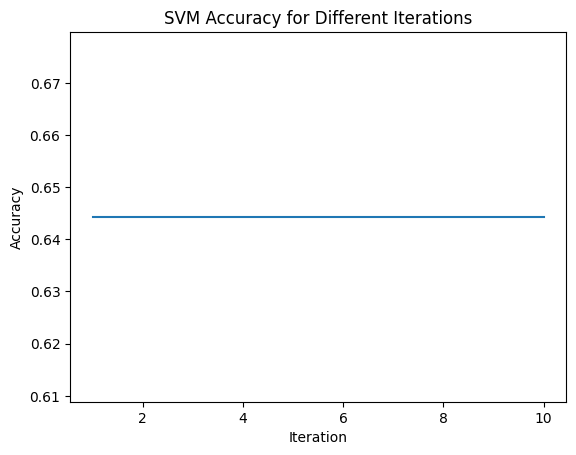

In [7]:
# Plot the training history
plt.plot(range(1, EPOCHS + 1), epoch_accuracies)
plt.title('SVM Accuracy for Different Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.show()